## Import

In [1]:
import torch.nn as nn
from  torch.utils.data import Dataset,DataLoader
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from glob import glob
import os,sys
import cv2
import segmentation_models_pytorch as smp

warnings.filterwarnings("ignore")

## Hyperparameter Setting

In [2]:
class CFG():
    def __init__(self):
        self.lr = 3e-4
        self.epoch = 10
        self.TTA_times = 0
        self.batch_size = 128
        self.image_size = (96,64)
        self.seed = 42
        self.fold = 5
        self.run_fold = 1
        self.device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
        print(self.device)

def setSeed(seed=42,tor=True,tensorf=False):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)#only one time
    pd.core.common.random_state(seed)
        
    # pytorch seed setting
    if tor:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

cfg = CFG()
setSeed(cfg.seed)

cuda:2


## Logger

In [3]:
class Logger():
    logger_dict={}
    logger_raw_dict={}
    log_category=None
    
    def __init__(self,name,layer=0):
        self.history=pd.DataFrame()
        self.epoch_history=pd.DataFrame()
        self.current_epoch_history=pd.DataFrame()
        self.name=name
        self.epoch=0
        self.layer=str(layer)
        if self.layer not in Logger.logger_dict.keys():
            Logger.logger_dict[self.layer] = {}
            Logger.logger_raw_dict[self.layer] = {}
            
    def __call__(self,**kwargs):
        new_row = pd.DataFrame(kwargs,index=[0])
        self.current_epoch_history=self.current_epoch_history.append(new_row)
    
    def __str__(self,r=3):
        output_str=''
        if len(self.current_epoch_history)>0:
            avg_epoch = self.get_current_epoch_avg()
            for log_c in avg_epoch.index:
                output_str+= 'avg{}:{} \t'.format(log_c,f'%.{r}f'%avg_epoch[log_c])
            return output_str
        else:
            avg_epoch = self.epoch_history.iloc[-1]
            for log_c in avg_epoch.index:
                output_str+= 'avg{}:{} \t'.format(log_c,f'%.{r}f'%avg_epoch[log_c])
            return output_str
        
    def get_current_epoch_avg(self):
        return self.current_epoch_history.mean()
    
    def get_best_record(self,category='loss',mode='min',unit='epoch'):
        _history = self.epoch_history if unit == 'epoch' else self.history
        if mode == 'min':
            best_index = _history[category].idxmin()
        else:
            best_index = _history[category].idxmax()
        return best_index, _history.iloc[best_index]

    def check_best(self,category='loss',mode='min',unit='epoch'):
        _history = self.epoch_history if unit == 'epoch' else self.history
        best_index,best_record = self.get_best_record(category,mode,unit)
        return (len(_history[category])-1)==best_index

    def save_epoch(self):
        if Logger.log_category==None:
            Logger.log_category = self.current_epoch_history.columns.to_list()
        self.epoch_history=self.epoch_history.append(self.get_current_epoch_avg().copy(),ignore_index=True).reset_index(drop=True)
        self.current_epoch_history['epoch'] = self.epoch
        self.epoch += 1
        self.history = self.history.append(self.current_epoch_history.copy()).reset_index(drop=True)
        self.current_epoch_history=pd.DataFrame(columns=Logger.log_category)
        Logger.logger_dict[self.layer][self.name]=self.history
        
        
    @staticmethod
    def plot(unit='epoch',show_category=None,figsize=(6.2,3)):
        
        show_category=Logger.log_category if show_category == None else show_category
        layer_list = sorted(list(Logger.logger_dict.keys()))
        figers, axs = plt.subplots(len(layer_list),len(show_category),figsize=(len(show_category)*figsize[0],len(layer_list)*figsize[1]))
        plt.subplots_adjust(hspace=0.5)

        if len(layer_list)>1 and len(show_category)>1:
            for lidx,l in enumerate(layer_list):
                keys_list=list(Logger.logger_dict[l].keys())
                for kidx,k in enumerate(keys_list):
                    for lcidx,log_c in enumerate(show_category):
                        _history=Logger.logger_dict[l][k]
                        _history = _history.groupby('epoch').mean() if unit == 'epoch' else _history
                        sns.lineplot(data=_history,x=range(len(_history)),y=log_c,ax=axs[lidx,lcidx],label=k).set(title = '{}'.format(log_c))
                        axs[lidx,lcidx].legend(loc='upper left')

        elif len(layer_list)>1:
            for lidx,l in enumerate(layer_list):
                keys_list=list(Logger.logger_dict[l].keys())
                for kidx,k in enumerate(keys_list):
                    for lcidx,log_c in enumerate(show_category):
                        _history=Logger.logger_dict[l][k]
                        _history = _history.groupby('epoch').mean() if unit == 'epoch' else _history
                        sns.lineplot(data=_history,x=range(len(_history)),y=log_c,ax=axs[lidx],label=k).set(title = '{}'.format(log_c))
                        axs[lidx].legend(loc='upper left')
        elif len(show_category)>1:
            for lidx,l in enumerate(layer_list):
                keys_list=list(Logger.logger_dict[l].keys())
                for kidx,k in enumerate(keys_list):
                    for lcidx,log_c in enumerate(show_category):
                        _history=Logger.logger_dict[l][k]
                        _history = _history.groupby('epoch').mean() if unit == 'epoch' else _history
                        sns.lineplot(data=_history,x=range(len(_history)),y=log_c,ax=axs[lcidx],label=k).set(title = '{}'.format(log_c))
                        axs[lcidx].legend(loc='upper left')
        else:
            keys_list=list(Logger.logger_dict[layer_list[0]].keys())
            for kidx,k in enumerate(keys_list):
                for lidx,log_c in enumerate(show_category):
                    _history=Logger.logger_dict[layer_list[0]][k]
                    _history = _history.groupby('epoch').mean() if unit == 'epoch' else _history
                    sns.lineplot(data=_history,x=range(len(_history)),y=log_c,ax=axs,label=k).set(title = '{}'.format(log_c))
                    axs.legend(loc='upper left')
        plt.show()

#example
#training_logger=Logger('Training')#default 0
#validation_logger=Logger('Validation')#default 0
#for i in range(10):
#    for i in range(10):
#        training_logger(acc=np.random.rand(),loss=random.random(),f1score=random.random())
#        validation_logger(acc=random.random(),loss=random.random(),f1score=random.random())
#    validation_logger.save_epoch()
#    training_logger.save_epoch()
#    validation_logger.check_best(category='acc',mode='max',unit='epoch')
#Logger.plot()
#Logger.plot('iter',show_category= ['loss'])

#display(validation_logger.history,validation_logger.epoch_history,validation_logger.history.groupby(by='epoch').mean())
#display(validation_logger.get_best_record(category='acc',mode='max',unit='epoch'))

## Data Pre-processing

In [4]:
data_path = os.path.abspath('/shared/Samsung/')
simulation_sem_paths = os.path.join(data_path, 'simulation_data', 'SEM', '*', '*', '*.png')
simulation_sem_paths = np.array(sorted(glob(simulation_sem_paths)))
simulation_depth_paths = os.path.join(data_path, 'simulation_data', 'Depth', '*', '*', '*.png')
simulation_depth_paths = np.array(sorted(glob(simulation_depth_paths) + glob(simulation_depth_paths)))
data_len = len(simulation_sem_paths)
data_len, len(simulation_sem_paths) == len(simulation_depth_paths)

(173304, True)

In [5]:
skf = StratifiedKFold(n_splits=cfg.fold, random_state=cfg.seed, shuffle=True)
splitlist = list(skf.split(range(data_len),[0]*data_len))
for i in range(5):
    print(f'Fold {i} : train {len(splitlist[i][0])}, valid {len(splitlist[i][1])}')

Fold 0 : train 138643, valid 34661
Fold 1 : train 138643, valid 34661
Fold 2 : train 138643, valid 34661
Fold 3 : train 138643, valid 34661
Fold 4 : train 138644, valid 34660


In [6]:
class SEMDataset(Dataset):
    def __init__(self, sem_path_list, depth_path_list=None, transform=None, label_transform=None):
        self.sem_path_list = sem_path_list
        self.depth_path_list = depth_path_list
        self.transform = transform
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        sem_path = self.sem_path_list[idx]
        sem_img = cv2.imread(sem_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            sem_img = self.transform(image=sem_img)['image']

        if self.depth_path_list is not None:
            depth_path = self.depth_path_list[idx]
            depth_img = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
            depth_img = depth_img / 255.

            if self.label_transform:
                depth_img = self.label_transform(image=depth_img)['image'].float()

            return (sem_path, depth_path), sem_img, depth_img
        
        else:
            return (sem_path, depth_path), sem_img
    
    def __len__(self):
        return len(self.sem_path_list)

In [24]:
class SEMDataset(Dataset):
    def __init__(self, sem_path_list, depth_path_list=None, transform=None, label_transform=None):
        self.sem_path_list = sem_path_list
        self.depth_path_list = depth_path_list
        self.transform = transform
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        sem_path = self.sem_path_list[idx]
        sem_img = cv2.imread(sem_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            if self.depth_path_list is not None:
                depth_path = self.depth_path_list[idx]
                depth_img = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
                depth_img = depth_img / 255.
                
                transformed = self.transform(image=sem_img, mask=depth_img)
                sem_img = transformed['image']
                depth_img = transformed['mask']

                return (sem_path, depth_path), sem_img, depth_img
            
            else:
                sem_img = self.transform(image=sem_img)['image']

                return sem_path, sem_img
        
        else:
            sem_img = sem_img / 255.

            if self.depth_path_list is not None:
                depth_path = self.depth_path_list[idx]
                depth_img = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
                depth_img = depth_img / 255.
                
                return (sem_path, depth_path), sem_img, depth_img
            
            else:
                return sem_path, sem_img
    
    def __len__(self):
        return len(self.sem_path_list)

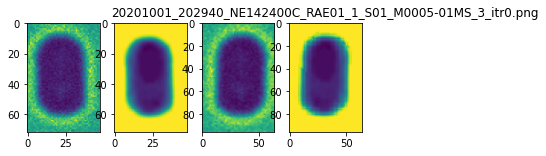

In [25]:
train_index = splitlist[0][0]
valid_index = splitlist[0][1]

train_sem_paths = simulation_sem_paths[train_index]
train_depth_paths = simulation_depth_paths[train_index]
valid_sem_paths = simulation_sem_paths[valid_index]
valid_depth_paths = simulation_depth_paths[valid_index]

train_sem_paths[:4], train_depth_paths[:4]

def get_png_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return img

def get_transform():
    label_transform = A.Compose([
        A.Resize(cfg.image_size[0],cfg.image_size[1],always_apply=True),
        A.HorizontalFlip(p=0.5),
        ToTensorV2()
    ])
    transform = A.Compose([
        A.Normalize(mean=[0.5],std=[0.5]),
        A.Resize(cfg.image_size[0],cfg.image_size[1],always_apply=True),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # A.ShiftScaleRotate(shift_limit=0.05, 
        #                    scale_limit=0.05, 
        #                    rotate_limit=5, 
        #                    p=0.5),
        
        ToTensorV2()
    ])


    return transform, label_transform

transform, label_transform = get_transform()

train_dataset = SEMDataset(train_sem_paths, train_depth_paths, transform, label_transform)

ex_idx = 0
img_name = train_sem_paths[ex_idx].split('/')[-1]

imgs = [
    get_png_image(train_sem_paths[ex_idx]),
    get_png_image(train_depth_paths[ex_idx]),
    train_dataset[ex_idx][1][0],
    train_dataset[ex_idx][2]
]

def display_images(imgs):
    for i in range(len(imgs)):
        plt.subplot(1, len(imgs), i+1)
        plt.imshow(imgs[i])
    plt.title(img_name)

display_images(imgs)


In [20]:
train_dataset[ex_idx][1].shape

torch.Size([1, 96, 64])

In [8]:
def get_dataloader(train_sem_paths, train_depth_paths, valid_sem_paths, valid_depth_paths):
    
    def get_transform():
        transform = A.Compose([
            A.Normalize(mean=[0.5],std=[0.5]),
            A.Resize(cfg.image_size[0],cfg.image_size[1],always_apply=True),
            ToTensorV2()
        ])

        label_transform = A.Compose([
            A.Resize(cfg.image_size[0],cfg.image_size[1],always_apply=True),
            ToTensorV2()
        ])

        return transform, label_transform

    transform, label_transform = get_transform()

    
    print('training data are processing..')
    train_dataset = SEMDataset(train_sem_paths, train_depth_paths, transform, label_transform)
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=cfg.batch_size,
                                  shuffle=True,
                                  num_workers=8,
                                  drop_last=True,
                                  pin_memory=True)
        
    print('validation data are processing..')
    valid_dataset = SEMDataset(valid_sem_paths, valid_depth_paths, transform, label_transform)
    valid_dataloader = DataLoader(valid_dataset,
                                  batch_size=cfg.batch_size,
                                  shuffle=False,
                                  num_workers=8,
                                  drop_last=False,
                                  pin_memory=True)
    
    return train_dataloader, valid_dataloader

In [9]:
# train_index = splitlist[0][0]
# valid_index = splitlist[0][1]

# def get_transform():
#         transform = A.Compose([
#             A.Normalize(mean=[0.5],std=[0.5]),
#             A.Resize(cfg.image_size[0],cfg.image_size[1],always_apply=True),
#             ToTensorV2()
#         ])

#         label_transform = A.Compose([
#             A.Resize(cfg.image_size[0],cfg.image_size[1],always_apply=True),
#             ToTensorV2()
#         ])

#         return transform, label_transform

# transform, label_transform = get_transform()

# train_sem_paths = simulation_sem_paths[train_index]
# train_depth_paths = simulation_depth_paths[train_index]
# valid_sem_paths = simulation_sem_paths[valid_index]
# valid_depth_paths = simulation_depth_paths[valid_index]
# train_dataset = SEMDataset(train_sem_paths[:10], train_depth_paths[:10], transform, label_transform)
# train_dataloader = DataLoader(train_dataset,
#                                 batch_size=2,
#                                 shuffle=True,
#                                 num_workers=0,
#                                 drop_last=True,
#                                 pin_memory=True)
# train_dataloader

# for paths, sem, depth in train_dataloader:
#     print(paths)
#     break

## Model

In [10]:
class ModelInstance():
    def __init__(self, model, optimizer, loss_function, scheduler=None, clip_grad=None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.certification = loss_function
        self.clip_grad = clip_grad
        
    def run_model(self, feature, label, update=True):
        feature = feature.to(cfg.device)
        label = label.to(cfg.device)
        
        if update:
            pred = self.model(feature)
        else:
            with torch.no_grad():
                pred = self.model(feature)
            
        loss = self.certification(pred, label)
        
        if update:
            loss.backward()
            if self.clip_grad:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=self.clip_grad)
            self.optimizer.step()
            self.optimizer.zero_grad()
            
        return  pred.cpu().detach(), loss.cpu().detach().item()
    
    def predict(self,feature):
        feature = feature.to(cfg.device)
        pred = self.model(feature)
        
        return pred.cpu().detach()
    


def create_model_instance():
    
    def certification(predict, label):
        loss = nn.MSELoss()(predict, label)
        return loss
    
    model = smp.UnetPlusPlus(
                    encoder_name="efficientnet-b0", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                    encoder_weights=None,           # use `imagenet` pre-trained weights for encoder initialization
                    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                    classes=1,                      # model output channels (number of classes in your dataset)
                    activation='sigmoid',
    ).to(cfg.device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, amsgrad=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-7, eps=1e-08, verbose=True)
    return ModelInstance(model, optimizer, certification, scheduler, None)

In [11]:
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score

def get_png_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = np.expand_dims(img, axis=-1)
    return img

def onehot_encoding(pred):
    return pred.argmax(dim=1)

def unnormalize(images):
        return (0.5*np.array(images)+0.5)*255

def run_epoch(instance, dataloader, epoch, logger, validmode):
    
    if validmode:
        instance.model.eval()
    else:
        instance.model.train()
        
    tbar = tqdm(dataloader, total=len(dataloader), desc='Valid' if validmode else 'Train')
    data_path, pred = None, None
    for data_path, feature, label in tbar:
        pred, loss = instance.run_model(feature, label, not validmode)
        logger(loss=loss)
        avg_log = logger.get_current_epoch_avg()
        tbar.set_postfix(loss = avg_log['loss'])
    logger.save_epoch()
    fig,axis = plt.subplots(1, 3, figsize=(12, 4))
    sample_idx = 0
    axis[0].imshow(get_png_image(data_path[0][sample_idx]), cmap='gray')
    axis[1].imshow(get_png_image(data_path[1][sample_idx]), cmap='gray')
    axis[2].imshow(np.transpose(pred[sample_idx] , (1, 2, 0)), cmap='gray')
    plt.show()
    

def inference(instance, dataloader,test=False):
    
    instance.model.eval()
    
    all_pred=[]
    all_label=[]
    all_id=[]
    
    tbar = tqdm(dataloader,total=len(dataloader), desc='')
    if test:
        for data_path, feature in tbar:
            pred = instance.predict(feature)
            all_pred.append(pred)
            all_id.append(data_path)

        all_pred = np.concatenate(all_pred, axis=0)
        all_id = np.concatenate(all_id, axis=0)
        return all_id,all_pred
    
    else:
        for data_path, feature, label in tbar:
            pred,loss = instance.run_model(feature, label, update=False)
            all_pred.append(pred)
            all_label.append(label)
            all_id.append(data_path)

        all_pred = np.concatenate(all_pred, axis=0)
        all_label = np.concatenate(all_label, axis=0)
        all_id = np.concatenate(all_id, axis=0)
        return data_path, all_pred, all_label

## Main

In [12]:
# for fold, (train_index, valid_index) in enumerate(splitlist):

#     instance = create_model_instance()
#     training_logger=Logger('Training',fold)
#     validation_logger=Logger('Validation',fold)
    
#     print(f'------------ Fold {fold} ------------')
#     train_sem_paths = simulation_sem_paths[train_index]
#     train_depth_paths = simulation_depth_paths[train_index]
#     valid_sem_paths = simulation_sem_paths[valid_index]
#     valid_depth_paths = simulation_depth_paths[valid_index]
    
#     train_dataloader, valid_dataloader = get_dataloader(simulation_sem_paths, simulation_depth_paths, valid_sem_paths, valid_depth_paths)

#     break

# validmode = False

# if validmode:
#     instance.model.eval()
# else:
#     instance.model.train()
    
# tbar = tqdm(train_dataloader, total=len(train_dataloader), desc='Valid' if validmode else 'Train')
# data_path, pred = None, None

# for data_path, feature, label in tbar:
#     pred, loss = instance.run_model(feature, label, validmode)
#     training_logger(loss=loss)
#     avg_log = training_logger.get_current_epoch_avg()
#     tbar.set_postfix(loss = avg_log['loss'])

# # logger.save_epoch()
# # fig,axis = plt.subplots(1, 3, figsize=(12, 4))
# # sample_idx = 0
# # axis[0].imshow(get_png_image(data_path[0][sample_idx]))
# # axis[1].imshow(get_png_image(data_path[1][sample_idx]))
# # axis[2].imshow(np.transpose(pred[sample_idx] , (1, 2, 0)), cmap='gray')
# # plt.show()

Train:   0%|          | 0/1083 [00:00<?, ?it/s]

------------ Fold 0 ------------
training data are processing..
validation data are processing..
Epoch 0/10:


Train: 100%|██████████| 1083/1083 [02:00<00:00,  9.02it/s, loss=0.000761]


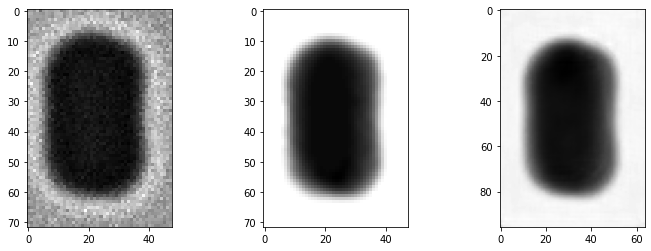

Valid: 100%|██████████| 271/271 [00:09<00:00, 28.87it/s, loss=0.00057] 


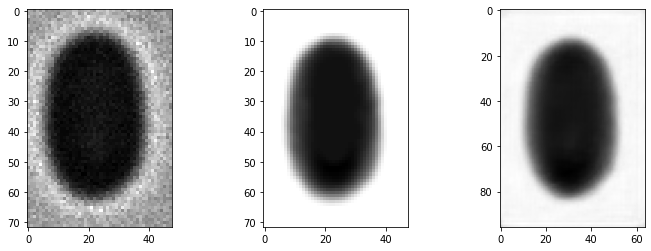

Train:   0%|          | 0/1083 [00:00<?, ?it/s]

--save mode--
Epoch 1/10:


Train: 100%|██████████| 1083/1083 [01:58<00:00,  9.14it/s, loss=0.000201]


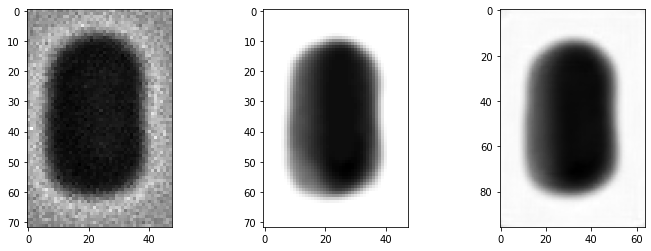

Valid: 100%|██████████| 271/271 [00:09<00:00, 29.52it/s, loss=0.000246]


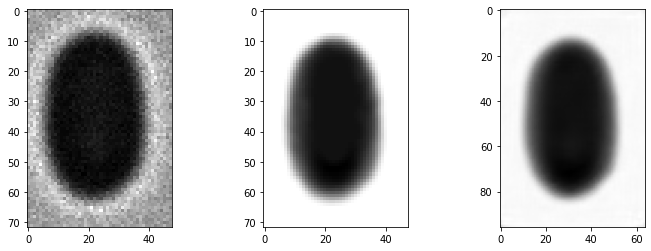

Train:   0%|          | 0/1083 [00:00<?, ?it/s]

--save mode--
Epoch 2/10:


Train: 100%|██████████| 1083/1083 [02:05<00:00,  8.62it/s, loss=0.000165]


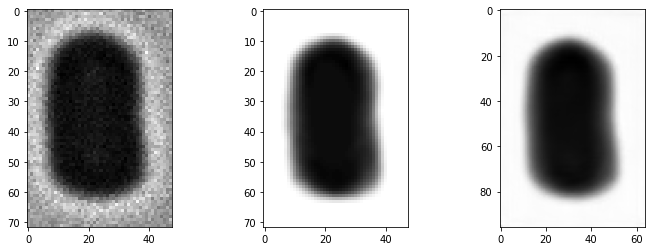

Valid: 100%|██████████| 271/271 [00:10<00:00, 26.47it/s, loss=0.000137]


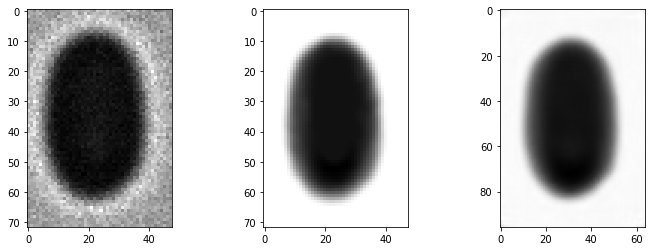

Train:   0%|          | 0/1083 [00:00<?, ?it/s]

--save mode--
Epoch 3/10:


Train: 100%|██████████| 1083/1083 [02:11<00:00,  8.23it/s, loss=0.000137]


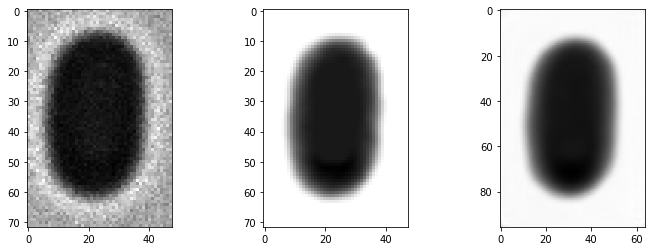

Valid: 100%|██████████| 271/271 [00:11<00:00, 23.48it/s, loss=0.000121]


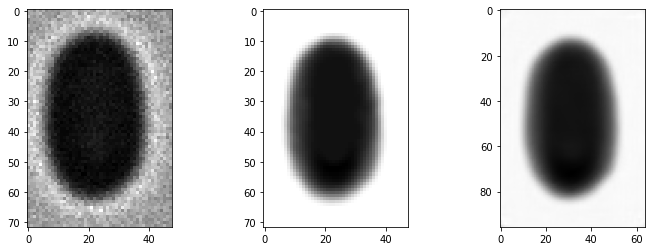

Train:   0%|          | 0/1083 [00:00<?, ?it/s]

--save mode--
Epoch 4/10:


Train: 100%|██████████| 1083/1083 [02:36<00:00,  6.92it/s, loss=0.00012]


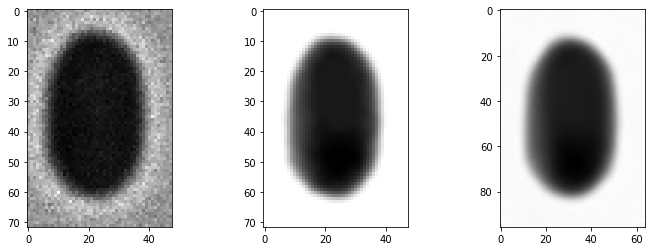

Valid: 100%|██████████| 271/271 [00:12<00:00, 22.56it/s, loss=9.69e-5]


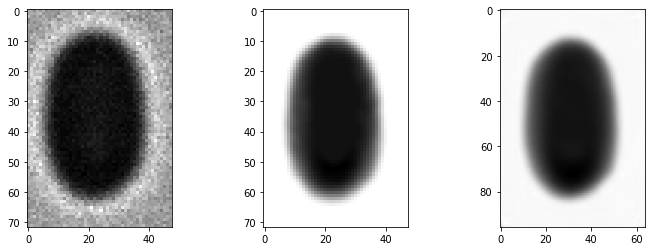

Train:   0%|          | 0/1083 [00:00<?, ?it/s]

--save mode--
Epoch 5/10:


Train: 100%|██████████| 1083/1083 [02:04<00:00,  8.72it/s, loss=0.000109]


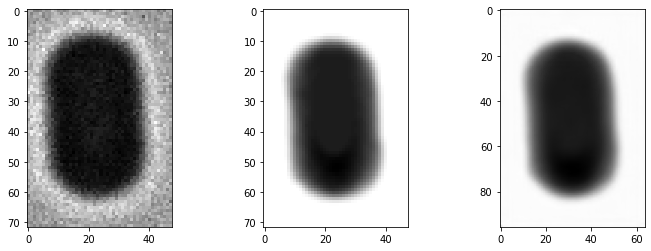

Valid: 100%|██████████| 271/271 [00:07<00:00, 37.38it/s, loss=8.84e-5]


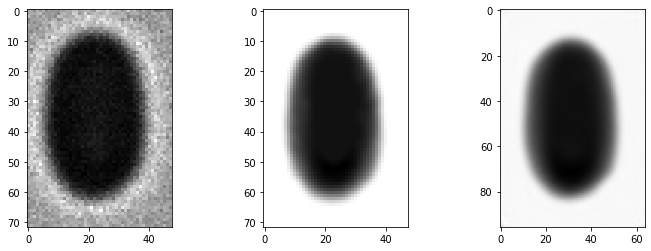

Train:   0%|          | 0/1083 [00:00<?, ?it/s]

--save mode--
Epoch 6/10:


Train: 100%|██████████| 1083/1083 [02:00<00:00,  8.98it/s, loss=0.000101]


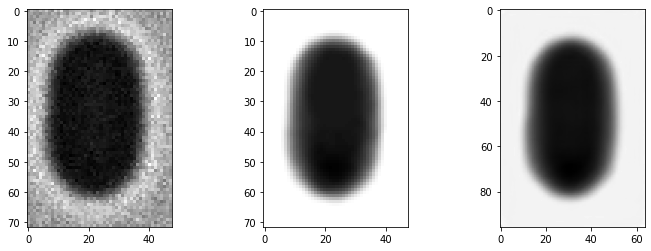

Valid: 100%|██████████| 271/271 [00:07<00:00, 36.72it/s, loss=9.28e-5]


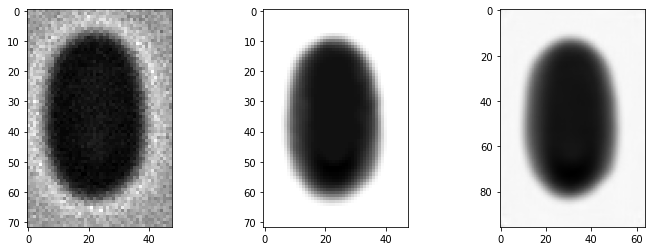

Train:   0%|          | 0/1083 [00:00<?, ?it/s]

Epoch 7/10:


Train: 100%|██████████| 1083/1083 [02:00<00:00,  9.02it/s, loss=9.46e-5]


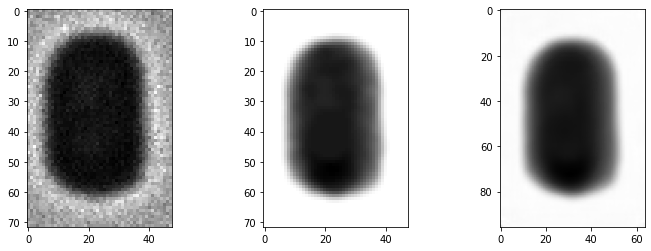

Valid: 100%|██████████| 271/271 [00:07<00:00, 33.95it/s, loss=8.4e-5] 


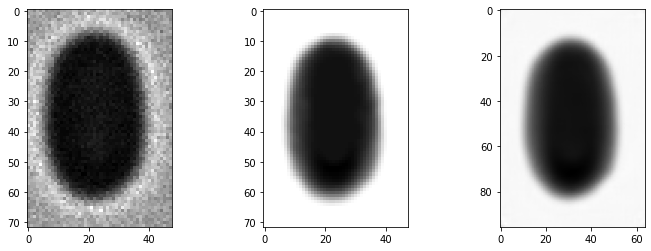

Train:   0%|          | 0/1083 [00:00<?, ?it/s]

--save mode--
Epoch 8/10:


Train: 100%|██████████| 1083/1083 [01:59<00:00,  9.10it/s, loss=8.76e-5]


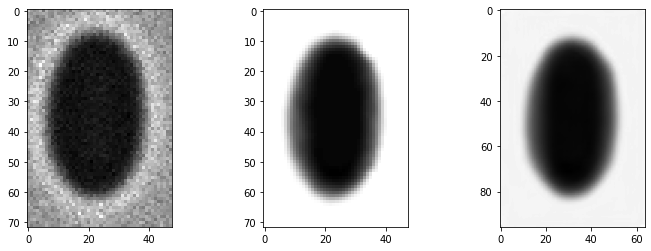

Valid: 100%|██████████| 271/271 [00:08<00:00, 30.95it/s, loss=8.41e-5]


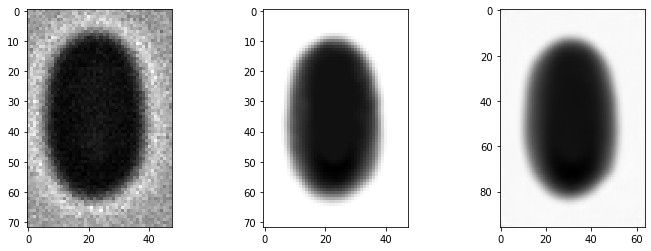

Train:   0%|          | 0/1083 [00:00<?, ?it/s]

Epoch 9/10:


Train: 100%|██████████| 1083/1083 [01:58<00:00,  9.14it/s, loss=8.41e-5]


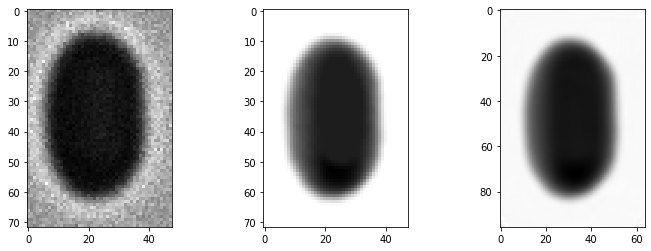

Valid: 100%|██████████| 271/271 [00:08<00:00, 30.42it/s, loss=7.57e-5]


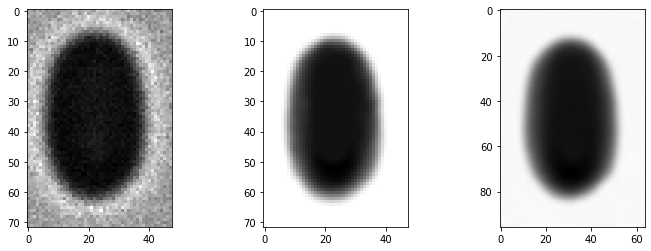

--save mode--


(9,
 loss    0.000076
 Name: 9, dtype: float64)

In [13]:
for fold, (train_index, valid_index) in enumerate(splitlist):
    instance = create_model_instance()
    training_logger=Logger('Training',fold)
    validation_logger=Logger('Validation',fold)
    
    print(f'------------ Fold {fold} ------------')
    train_sem_paths = simulation_sem_paths[train_index]
    train_depth_paths = simulation_depth_paths[train_index]
    valid_sem_paths = simulation_sem_paths[valid_index]
    valid_depth_paths = simulation_depth_paths[valid_index]
    
    train_dataloader, valid_dataloader = get_dataloader(train_sem_paths, train_depth_paths, valid_sem_paths, valid_depth_paths)

    for epoch in range(cfg.epoch):
        print(f'Epoch {epoch}/{cfg.epoch}:')
        run_epoch(instance, train_dataloader, epoch, training_logger, False)
        run_epoch(instance, valid_dataloader, epoch, validation_logger, True)
        if instance.scheduler:
            instance.scheduler.step(validation_logger.history.iloc[-1]['loss'])
        if validation_logger.check_best(category='loss', mode='min'):
            print('--save mode--')
            torch.save(instance.model.state_dict(), 'best_model.pkl')
    display(validation_logger.get_best_record(category='loss', mode='min'))
    if cfg.run_fold == fold+1:
        break